DeepLarning Couse HSE 2016 fall: 
* Arseniy Ashuha, you can text me ```ars.ashuha@gmail.com```,
* ```https://vk.com/ars.ashuha``` 
* partially reusing https://github.com/ebenolson/pydata2015

<h1 align="center"> Image Captioning </h1> 

In this seminar you'll be going through the image captioning pipeline.

To begin with, let us download the dataset of image features from a pre-trained GoogleNet.



In [1]:
!wget https://www.dropbox.com/s/3hj16b0fj6yw7cc/data.tar.gz?dl=1 -O data.tar.gz
!tar -xvzf data.tar.gz

--2017-12-16 22:50:40--  https://www.dropbox.com/s/3hj16b0fj6yw7cc/data.tar.gz?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.1, 2620:100:601c:1::a27d:601
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.1|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://dl.dropboxusercontent.com/content_link/iC2sRTd0mW6ahmYrpUhXhEPj3lsCuumHDBc7BqLaqs0eAifYddac2GXYA6qdda5B/file?dl=1 [following]
--2017-12-16 22:50:40--  https://dl.dropboxusercontent.com/content_link/iC2sRTd0mW6ahmYrpUhXhEPj3lsCuumHDBc7BqLaqs0eAifYddac2GXYA6qdda5B/file?dl=1
Resolving dl.dropboxusercontent.com (dl.dropboxusercontent.com)... 162.125.6.6, 2620:100:601c:6::a27d:606
Connecting to dl.dropboxusercontent.com (dl.dropboxusercontent.com)|162.125.6.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 506221998 (483M) [application/binary]
Saving to: ‘data.tar.gz’

data.tar.gz         100%[===================>] 482.77M  39.4MB/s    in 13s     

2017-

### Data preprocessing

In [2]:
%%time
# Read Dataset
import numpy as np
import pickle

img_codes = np.load("data/image_codes.npy")
captions = pickle.load(open('data/caption_tokens.pcl', 'rb'))

CPU times: user 464 ms, sys: 504 ms, total: 968 ms
Wall time: 4.99 s


In [3]:
print ("each image code is a 1000-unit vector:", img_codes.shape)
print (img_codes[0,:10])
print ('\n\n')
print ("for each image there are 5-7 descriptions, e.g.:\n")
print ('\n'.join(captions[0]))

each image code is a 1000-unit vector: (123287, 1000)
[ 1.38901556 -3.82951474 -1.94360816 -0.5317238  -0.03120959 -2.87483215
 -2.9554503   0.6960277  -0.68551242 -0.7855981 ]



for each image there are 5-7 descriptions, e.g.:

a man with a red helmet on a small moped on a dirt road
man riding a motor bike on a dirt road on the countryside
a man riding on the back of a motorcycle
a dirt path with a young person on a motor bike rests to the foreground of a verdant area with a bridge and a background of cloud wreathed mountains
a man in a red shirt and a red hat is on a motorcycle on a hill side


In [4]:
#split descriptions into tokens
for img_i in range(len(captions)):
    for caption_i in range(len(captions[img_i])):
        sentence = captions[img_i][caption_i] 
        captions[img_i][caption_i] = ["#START#"]+sentence.split(' ')+["#END#"]


In [5]:
# Build a Vocabulary
from collections import Counter
word_counts = Counter()

for img_captions in captions:
    for caption in img_captions:
        word_counts.update(caption)

In [6]:
vocab  = ['#UNK#', '#START#', '#END#']
vocab += [k for k, v in word_counts.items() if v >= 5]
n_tokens = len(vocab)

assert 10000 <= n_tokens <= 10500

word_to_index = {w: i for i, w in enumerate(vocab)}

In [7]:
PAD_ix = -1
UNK_ix = vocab.index('#UNK#')

#good old as_matrix for the third time
def as_matrix(sequences,max_len=None):
    max_len = max_len or max(map(len,sequences))
    
    matrix = np.zeros((len(sequences),max_len),dtype='int32')+PAD_ix
    for i,seq in enumerate(sequences):
        row_ix = [word_to_index.get(word,UNK_ix) for word in seq[:max_len]]
        matrix[i,:len(row_ix)] = row_ix
    
    return matrix


In [8]:
#try it out on several descriptions of a random image
as_matrix(captions[1337])

array([[   3,   64,  322,  206,   32,   50,  588,   21,  171,  172,   36,
        1836,   14,   -1,   -1],
       [   3,  171,  172,  183, 1405,   43, 1836,   36,  186, 1381,  588,
          14,   -1,   -1,   -1],
       [   3,    4,  206,   32,   50,  588,   21,  171,   24, 3575,   65,
          27,  605,  353,   14],
       [   3,    4,    5,   75,  449,    9,    4,    5,  102,   14,   -1,
          -1,   -1,   -1,   -1],
       [   3,   64,  322,  206,   32,   50,  588,   21,  171,  172,   65,
          27, 3576,   14,   -1]], dtype=int32)

### Mah Neural Network

In [9]:
# network shapes. 
CNN_FEATURE_SIZE = img_codes.shape[1]
EMBED_SIZE = 128 #pls change me if u want
LSTM_UNITS = 200 #pls change me if u want

In [10]:
import theano
import theano.tensor as T

In [11]:
# Input Variable
sentences = T.imatrix()# [batch_size x time] of word ids
image_vectors = T.matrix() # [batch size x unit] of CNN image features
sentence_mask = T.neq(sentences,PAD_ix)

In [12]:
import lasagne
from lasagne.layers import *

In [13]:
#network inputs
l_words = InputLayer((None,None),sentences )
l_mask = InputLayer((None,None),sentence_mask )

In [14]:
n_tokens,EMBED_SIZE

(10373, 128)

In [15]:
#embeddings for words 
l_word_embeddings = EmbeddingLayer(l_words,n_tokens,EMBED_SIZE)

#cudos for using some pre-trained embedding :)

In [16]:
# input layer for image features
l_image_features = InputLayer((None,CNN_FEATURE_SIZE),image_vectors )

#convert 1000 image features from googlenet to whatever LSTM_UNITS you have set
#it's also a good idea to add some dropout here and there
l_image_features_small = DropoutLayer(l_image_features,0.5)
l_image_features_small = DenseLayer(l_image_features_small, LSTM_UNITS)
assert l_image_features_small.output_shape == (None,LSTM_UNITS)


In [17]:
# Concatinate image features and word embedings in one sequence 
decoder = LSTMLayer(l_word_embeddings,
                    num_units=LSTM_UNITS,
                    cell_init=l_image_features_small,
                    mask_input=l_mask,
                    grad_clipping=5)

#find out better recurrent architectures for bonus point
#    * takes word embeddings as an input
#    * has LSTM_UNITS units in the final layer
#    * has cell_init (or hid init for gru) set to converted image features
#    * mask_input = input_mask
#    * don't forget the grad clipping (~5-10)

#find out better recurrent architectures for bonus point

In [83]:
# Decoding of rnn hiden states
from broadcast import BroadcastLayer,UnbroadcastLayer

#apply whatever comes next to each tick of each example in a batch. Equivalent to 2 reshapes
broadcast_decoder_ticks = BroadcastLayer(decoder,(0,1))
print ("broadcasted decoder shape = ",broadcast_decoder_ticks.output_shape)

#predict probabilities for next tokens
predicted_probabilities_each_tick = DenseLayer(broadcast_decoder_ticks,n_tokens,
                                               nonlinearity=lasagne.nonlinearities.softmax)
# maybe a more complicated architecture will work better?

#un-broadcast back into (batch,tick,probabilities)
predicted_probabilities = UnbroadcastLayer(predicted_probabilities_each_tick,
                                           broadcast_layer=broadcast_decoder_ticks)

print ("output shape = ",predicted_probabilities.output_shape)

#remove if you know what you're doing (e.g. 1d convolutions or fixed shape)
assert predicted_probabilities.output_shape == (None, None, 10373)

broadcasted decoder shape =  (None, 200)
output shape =  (None, None, 10373)


In [72]:
# Decoding of rnn hiden states
from broadcast import BroadcastLayer,UnbroadcastLayer

#apply whatever comes next to each tick of each example in a batch. Equivalent to 2 reshapes
broadcast_decoder_ticks = BroadcastLayer(decoder,(0,1))
print ("broadcasted decoder shape = ",broadcast_decoder_ticks.output_shape)

broadcasted decoder shape =  (None, 200)


In [73]:
#predict probabilities for next tokens
predicted_probabilities_each_tick = DenseLayer(broadcast_decoder_ticks,n_tokens,
                                               nonlinearity=lasagne.nonlinearities.softmax)
# maybe a more complicated architecture will work better?

In [74]:
#un-broadcast back into (batch,tick,probabilities)
predicted_probabilities = UnbroadcastLayer(predicted_probabilities_each_tick,
                                           broadcast_layer=broadcast_decoder_ticks)

print ("output shape = ",predicted_probabilities.output_shape)

#remove if you know what you're doing (e.g. 1d convolutions or fixed shape)
assert predicted_probabilities.output_shape == (None, None, 10373)

output shape =  (None, None, 10373)


### Some tricks
* If you train large network, it is usually a good idea to make a 2-stage prediction
    1. (large recurrent state) -> (bottleneck e.g. 256)
    2. (bottleneck) -> (vocabulary size)
    * this way you won't need to store/train (large_recurrent_state x vocabulary size) matrix
* Also maybe use Hierarchical Softmax?
    * https://gist.github.com/justheuristic/581853c6d6b87eae9669297c2fb1052d




In [142]:
next_word_probas = get_output(predicted_probabilities)

reference_answers = sentences[:,1:]
output_mask = sentence_mask[:,1:]
predictions_flat = next_word_probas[:,:-1].reshape((-1,n_tokens))
#write symbolic loss function to train NN for
loss = lasagne.objectives.categorical_crossentropy(predictions_flat, reference_answers.reshape((-1,))
)
#mean over non-PAD tokens
loss = (loss.reshape(reference_answers.shape)*output_mask).sum() / output_mask.sum()

In [143]:
#trainable NN weights
weights = get_all_params(predicted_probabilities,trainable=True)
updates = lasagne.updates.adam(loss,get_all_params(predicted_probabilities,trainable=True))
updates = lasagne.updates.adam(loss,weights)

In [144]:
#compile a functions for training and evaluation
#please not that your functions must accept image features as FIRST param and sentences as second one
train_step = theano.function([image_vectors,sentences],loss,updates=updates)
val_step   = theano.function([image_vectors,sentences],loss)
#for val_step use deterministic=True if you have any dropout/noize

# Training

* You first have to implement a batch generator
* Than the network will get trained the usual way

In [189]:
captions = np.array(captions)

In [190]:
from random import choice

def generate_batch(images,captions,batch_size,max_caption_len=None):
    
    #sample random numbers for image/caption indicies
    random_image_ix = np.random.randint(0,len(images),size=batch_size)
    
    #get images
    batch_images = images[random_image_ix]
    
    #5-7 captions for each image
    captions_for_batch_images = captions[random_image_ix]
    
    #pick 1 from 5-7 captions for each image
    batch_captions = list(map(choice,captions_for_batch_images))
    
    #convert to matrix
    batch_captions_ix = as_matrix(batch_captions,max_len=max_caption_len)
    
    return batch_images, batch_captions_ix
    

In [191]:
generate_batch(img_codes,captions,3)

(array([[-1.34084308, -1.8518343 , -2.42520118, ..., -1.56643295,
          4.68985939,  2.45227909],
        [-3.48967695, -1.26962245,  0.83085537, ..., -1.10183334,
         -0.67846751,  0.73619628],
        [-2.23414063,  0.28520972, -1.26266634, ..., -0.40570045,
          3.42479324,  1.84230793]], dtype=float32),
 array([[   3,    4,   68,   32,    4,  129,  102,   65,   27,   94,  491,
           74,   82,   83,  845,   92,   14],
        [   3,  186,   39,    4,  190,   21,    4,  399,  184, 4970,   27,
         4131,  762, 3342,   14,   -1,   -1],
        [   3,   18,    5,   39,   59,    4,  980,    6,    4, 2032,   32,
         3625,   14,   -1,   -1,   -1,   -1]], dtype=int32))

### Main loop
* We recommend you to periodically evaluate the network using the next "apply trained model" block
 *  its safe to interrupt training, run a few examples and start training again

In [192]:
batch_size=50 #adjust me
n_epochs=100 #adjust me
n_batches_per_epoch = 50 #adjust me
n_validation_batches = 5 #how many batches are used for validation after each epoch


In [193]:
from tqdm import tqdm

for epoch in range(n_epochs):
    
    train_loss=0
    for _ in tqdm(range(n_batches_per_epoch)):
        train_loss += train_step(*generate_batch(img_codes,captions,batch_size))
    train_loss /= n_batches_per_epoch
    
    val_loss=0
    for _ in range(n_validation_batches):
        val_loss += val_step(*generate_batch(img_codes,captions,batch_size))
    val_loss /= n_validation_batches
    
    print('\nEpoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))

print("Finish :)")

  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 0, train loss: 4.758736496854485, val loss: 4.7293926069980925


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 1, train loss: 4.568328658046878, val loss: 4.361556663806054


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 2, train loss: 4.376298177481239, val loss: 4.364687388589431


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 3, train loss: 4.303684233718836, val loss: 4.12044778604775


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 4, train loss: 4.166154902604811, val loss: 4.0034578921389645


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 5, train loss: 4.074897691410133, val loss: 3.8736459816651125


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 6, train loss: 3.960274872404242, val loss: 3.952111395614428


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 7, train loss: 3.904429326931618, val loss: 3.8545826232758102


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 8, train loss: 3.8394623374255694, val loss: 3.7452223872620194


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 9, train loss: 3.7615506238461354, val loss: 3.7134533583238762


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 10, train loss: 3.7475161611285692, val loss: 3.6124704760398423


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 11, train loss: 3.6961476238888284, val loss: 3.677170470611575


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 12, train loss: 3.6387794184648112, val loss: 3.5505828314920302


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 13, train loss: 3.5686525834665144, val loss: 3.5966799025591802


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 14, train loss: 3.5464023446552617, val loss: 3.506244397792493


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 15, train loss: 3.5093112716747, val loss: 3.4024557852663975


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 16, train loss: 3.4988105321321505, val loss: 3.437124327608091


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 17, train loss: 3.4406065255928087, val loss: 3.6520807941697497


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 18, train loss: 3.4368865949226586, val loss: 3.5133176317478374


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 19, train loss: 3.4119276951603723, val loss: 3.2760475941064398


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 20, train loss: 3.360807661240812, val loss: 3.361648315624034


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 21, train loss: 3.358604205604714, val loss: 3.3297864569751234


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 22, train loss: 3.3253344020577, val loss: 3.3718200878788442


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 23, train loss: 3.3174886477223695, val loss: 3.3286195983824856


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 24, train loss: 3.288947838938345, val loss: 3.4208249342263697


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 25, train loss: 3.276354002159798, val loss: 3.2835988281814585


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 26, train loss: 3.2462632683122337, val loss: 3.307356008676396


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 27, train loss: 3.291374360597111, val loss: 3.2285429529345024


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 28, train loss: 3.2245434453102826, val loss: 3.2099167671668694


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 29, train loss: 3.2262615884863006, val loss: 3.0716545575162377


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 30, train loss: 3.210411367067999, val loss: 3.2717397985802656


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 31, train loss: 3.214194308685592, val loss: 3.1172018535201658


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 32, train loss: 3.20439304259801, val loss: 3.1693330356350558


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 33, train loss: 3.1489517188269245, val loss: 3.1552963455833782


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 34, train loss: 3.192053957004587, val loss: 3.140033098054347


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 35, train loss: 3.1917430672630513, val loss: 3.2615960527806864


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 36, train loss: 3.1621561741401036, val loss: 3.1626028333102285


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 37, train loss: 3.0877191334909226, val loss: 3.10669325666601


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 38, train loss: 3.059393256173002, val loss: 3.206631680030842


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 39, train loss: 3.103422940476342, val loss: 3.070388114363314


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 40, train loss: 3.1060911548817387, val loss: 3.0648129952482477


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 41, train loss: 3.071381679976168, val loss: 2.990067146285385


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 42, train loss: 3.1029044423358205, val loss: 3.134434558692921


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 43, train loss: 3.0961733958124693, val loss: 3.0376934851572632


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 44, train loss: 3.11809455160933, val loss: 3.0421273177442942


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 45, train loss: 3.0823547299212093, val loss: 3.1279413037292243


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 46, train loss: 3.0627057152174024, val loss: 3.0434189072959295


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 47, train loss: 3.051956020837054, val loss: 3.0082197972330844


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 48, train loss: 3.0253894549767444, val loss: 2.919990449711667


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 49, train loss: 3.0737793549002426, val loss: 2.948075342267717


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 50, train loss: 3.021983144669, val loss: 2.9662387650392033


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 51, train loss: 2.98152088373862, val loss: 3.012427165082584


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 52, train loss: 3.0188714424478427, val loss: 2.9824250666932235


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 53, train loss: 2.991113057400525, val loss: 3.060937676111826


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 54, train loss: 2.9968824216087313, val loss: 3.07073308759459


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 55, train loss: 2.966831918776685, val loss: 2.8976631034921714


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 56, train loss: 2.9853340522319574, val loss: 2.9950976522678223


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 57, train loss: 2.9504304112856743, val loss: 2.9738888442816456


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 58, train loss: 2.9779235730254117, val loss: 3.039564008800873


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 59, train loss: 2.9890280799288775, val loss: 2.889248066139257


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 60, train loss: 2.9270577924031578, val loss: 2.819777886300495


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 61, train loss: 3.0032375890742746, val loss: 2.8712747563354295


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 62, train loss: 2.9135426440642083, val loss: 3.109901811713922


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 63, train loss: 2.944384635980259, val loss: 2.9431673979867745


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 64, train loss: 2.962240343227618, val loss: 2.9642766324798537


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 65, train loss: 2.919972315958446, val loss: 2.96400974926972


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 66, train loss: 2.945541416177048, val loss: 2.897453814998639


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 67, train loss: 2.9142122529204433, val loss: 2.9847035846726344


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 68, train loss: 2.957252328789102, val loss: 2.8268224415249543


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 69, train loss: 2.95332309063356, val loss: 2.944939321992446


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 70, train loss: 2.8876635589875184, val loss: 2.888180395869978


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 71, train loss: 2.902589009132613, val loss: 2.8024660495186406


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 72, train loss: 2.912378804188251, val loss: 2.941950454655045


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 73, train loss: 2.879954927624195, val loss: 2.9337310760693986


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 74, train loss: 2.9063376991218393, val loss: 2.851288408263062


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 75, train loss: 2.8774563174413834, val loss: 2.9186000611617557


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 76, train loss: 2.8664826851786143, val loss: 2.822787129513646


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 77, train loss: 2.8746373059069183, val loss: 2.9715320024479874


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 78, train loss: 2.8718943508562718, val loss: 2.7857509193192254


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 79, train loss: 2.8979465228908143, val loss: 2.898945774543942


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 80, train loss: 2.8887572381618067, val loss: 2.8451435144064403


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 81, train loss: 2.8715024178147592, val loss: 2.8351607429026857


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 82, train loss: 2.836446128009847, val loss: 2.6899423900495756


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 83, train loss: 2.8454602402381646, val loss: 2.764904574386653


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 84, train loss: 2.854343698808082, val loss: 2.792837427573038


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 85, train loss: 2.880197662416395, val loss: 2.6643708646095723


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 86, train loss: 2.8078106311485245, val loss: 2.7876355541240243


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 87, train loss: 2.852475038268914, val loss: 2.8750831221543045


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 88, train loss: 2.859413067896463, val loss: 2.8601476437013593


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 89, train loss: 2.8429862996950472, val loss: 2.6858885166688404


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 90, train loss: 2.8209830762253243, val loss: 2.8658454761068746


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 91, train loss: 2.813311285580817, val loss: 2.903832954814457


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 92, train loss: 2.852575632630336, val loss: 2.8470714886883184


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 93, train loss: 2.846040170836632, val loss: 2.7612541549373404


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 94, train loss: 2.836030459447244, val loss: 2.7632832487091337


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 95, train loss: 2.817175446516687, val loss: 2.892058826496723


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 96, train loss: 2.8417936425568744, val loss: 2.981806978909092


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 97, train loss: 2.7774652607624173, val loss: 2.7077688475000676


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 98, train loss: 2.8149475348372164, val loss: 2.7589105688275177


100%|██████████| 50/50 [01:16<00:00,  1.54s/it]



Epoch: 99, train loss: 2.8455680419039653, val loss: 2.7657242734213363
Finish :)


### apply trained model

In [195]:
#the same kind you did last week, but a bit smaller
from pretrained_lenet import build_model,preprocess,MEAN_VALUES

# build googlenet
lenet = build_model()

#load weights
lenet_weights = pickle.load(open('data/blvc_googlenet.pkl', 'rb'), encoding='latin1')['param values']
set_all_param_values(lenet["prob"], lenet_weights)

#compile get_features
cnn_input_var = lenet['input'].input_var
cnn_feature_layer = lenet['loss3/classifier']
get_cnn_features = theano.function([cnn_input_var], lasagne.layers.get_output(cnn_feature_layer))

In [196]:
import skimage.transform
def preprocess(im):
    if len(im.shape) == 2:
        im = im[:, :, np.newaxis]
        im = np.repeat(im, 3, axis=2)
    # Resize so smallest dim = 224, preserving aspect ratio
    h, w, _ = im.shape
    if h < w:
        im = skimage.transform.resize(im, (224, w*224//h), preserve_range=True)
    else:
        im = skimage.transform.resize(im, (h*224//w, 224), preserve_range=True)

    # Central crop to 224x224
    h, w, _ = im.shape
    im = im[h//2-112:h//2+112, w//2-112:w//2+112]
    
    rawim = np.copy(im).astype('uint8')
    
    # Shuffle axes to c01
    im = np.swapaxes(np.swapaxes(im, 1, 2), 0, 1)
    
    # Convert to BGR
    im = im[::-1, :, :]

    im = im - MEAN_VALUES
    return im[np.newaxis].astype('float32')


In [197]:
from matplotlib import pyplot as plt
%matplotlib inline

#sample image
img = plt.imread('data/Dog-and-Cat.jpg')
img = preprocess(img)

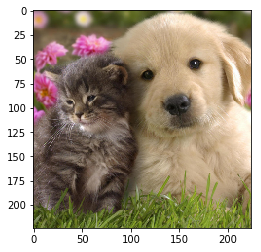

In [198]:
#deprocess and show, one line :)
from pretrained_lenet import MEAN_VALUES
plt.imshow(np.transpose((img[0] + MEAN_VALUES)[::-1],[1,2,0]).astype('uint8'))

## Generate caption

In [200]:
last_word_probas = get_output(predicted_probabilities,deterministic=True)[:,-1]
#TRY OUT deterministic=True if you want more steady results

get_probs = theano.function([image_vectors,sentences], last_word_probas)

#this is exactly the generation function from week5 classwork,
#except now we condition on image features instead of words
def generate_caption(image,caption_prefix = ("START",),t=1,sample=False,max_len=100):
    image_features = get_cnn_features(image)
    caption = list(caption_prefix)
    for _ in range(max_len):
        
        next_word_probs = get_probs(image_features,as_matrix([caption]))
        next_word_probs = next_word_probs.ravel()
        assert len(next_word_probs.shape) ==1 #must be one-dimensional
        #apply temperature
        next_word_probs = next_word_probs**t / np.sum(next_word_probs**t)

        if sample:
            next_word = np.random.choice(vocab,p=next_word_probs) 
        else:
            next_word = vocab[np.argmax(next_word_probs)]

        caption.append(next_word)

        if next_word=="#END#":
            break
            
    return caption

# Demo
### Find at least 10 images to test it on.
* Seriously, that's part of an assignment. Go get at least 10 pictures to get captioned
* Make sure it works okay on __simple__ images before going to something more comples
* Photos, not animation/3d/drawings, unless you want to train CNN network on anime
* Mind the aspect ratio (see what `preprocess` does to your image)

In [201]:
#apply your network on image sample you found
#
#

## examples where network provides reasonable captions (at least sometimes :) )

a man holding a remote control in his hands


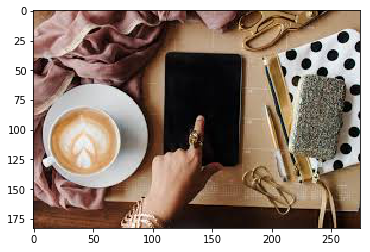

In [213]:
from skimage import io
def show_cap(url_path):
    image = io.imread(url_path)
    plt.imshow(image)
    print(' '.join(generate_caption(preprocess(image),t=1.)[1:-1]))

url_path = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTHHJrUy9p8iECVqHkj1ZQcqUPjdJ9S9_9wksXgq2Yf_mtJSxJxyA"    
show_cap(url_path)

a man in a black shirt and a tie


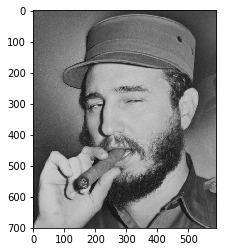

In [289]:
url_path = "https://cdn.images.express.co.uk/img/dynamic/galleries/x701/93382.jpg"    
show_cap(url_path)

a man is standing on a street corner


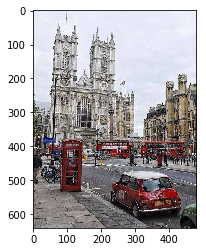

In [214]:
url_path = "https://scontent-lax3-2.xx.fbcdn.net/v/t1.0-9/25151921_1593622857386578_2775677328722238807_n.png?oh=3337532bd891b6370db5eb53910a6c75&oe=5AC75359"    
show_cap(url_path)

a cat is standing in a tree


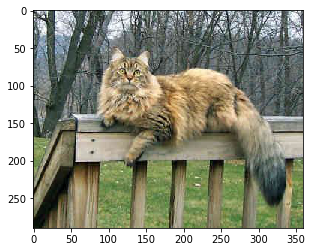

In [221]:
url_path = "https://i.pinimg.com/564x/06/04/f2/0604f2c32dc37382127d12076e1b8937.jpg"    
show_cap(url_path)

a woman in a suit and tie


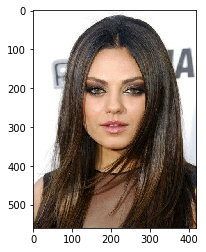

In [228]:
url_path = "https://i.pinimg.com/564x/a5/87/c6/a587c6a929eb608f5d7f0944a665333e.jpg"    
show_cap(url_path)

a man holding a tennis racket in his hand


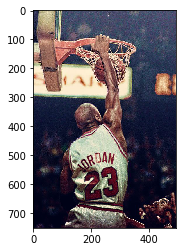

In [236]:
url_path = "https://i.pinimg.com/564x/31/0c/cc/310ccc98ade3a3723b3f98c574763e35.jpg"    
show_cap(url_path)

a man holding a laptop computer


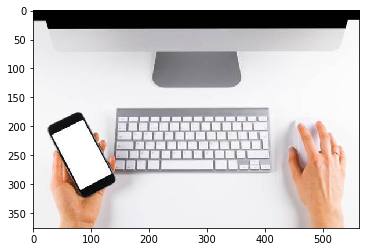

In [238]:
url_path = "https://i.pinimg.com/564x/29/9b/a2/299ba251dc4f459b93e8cf9a128110e7.jpg"    
show_cap(url_path)

a table with a white and white rose


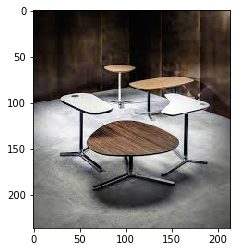

In [249]:
url_path = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSQrUoKC4FVbZcf-RGjYQ2AWB40ta7uftOabMDcIpsj3Gdgqn2NYQ"    
show_cap(url_path)

a man holding a laptop on a laptop


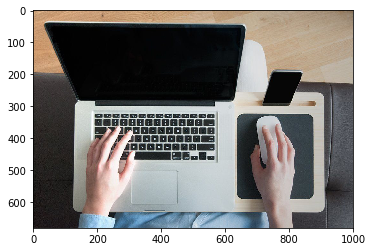

In [252]:
url_path = "http://www.mailshop.co.uk/dw/image/v2/ABBL_PRD/on/demandware.static/-/Sites-merchantry/default/dwa15fd420/images/large/b12b8589a4add9f6365defd70941b4a30489ce0f579ee20d8414fc82c0d4fbff.jpg?sw=1000&sh=1000&sm=fit"    
show_cap(url_path)

a man on a beach with a blue umbrella


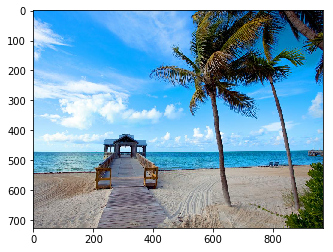

In [256]:
url_path = "http://travel.home.sndimg.com/content/dam/images/travel/fullset/2015/08/03/top-florida-beaches/key-west-beach-florida.jpg.rend.hgtvcom.966.725.suffix/1491580836931.jpeg"    
show_cap(url_path)

a man is riding a surfboard on a beach


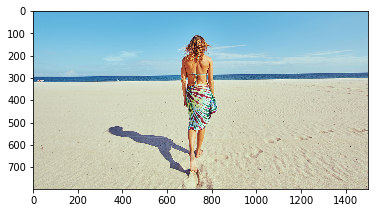

In [257]:
url_path = "https://2486634c787a971a3554-d983ce57e4c84901daded0f67d5a004f.ssl.cf1.rackcdn.com/plunge-hotel/media/Plunge-rotator6-592dc80788dc5.jpg"    
show_cap(url_path)

a man is flying a kite on a beach


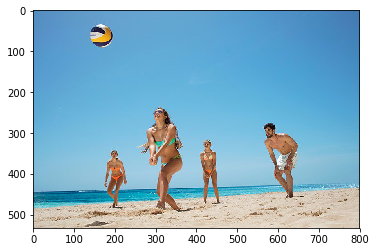

In [266]:
url_path = "https://media-cdn.tripadvisor.com/media/photo-o/10/f2/ba/83/sunscape-dominican-beach.jpg"    
show_cap(url_path)

a man on a snowboard on a snowy hill


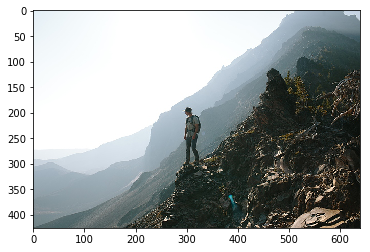

In [267]:
url_path = "http://absfreepic.com/absolutely_free_photos/small_photos/standing-man-on-mountains-5472x3648_87806.jpg"    
show_cap(url_path)

a man is flying a kite in the sky


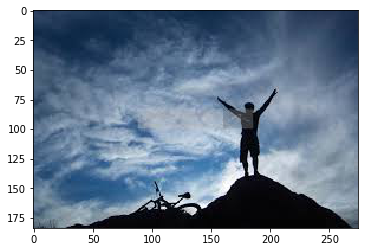

In [269]:
url_path = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQ31h85GfiYFgBQTnLcPOaH2Bj1gYMLAqTb2o63M40W_zXySt7a"    
show_cap(url_path)

a table with a clock on it


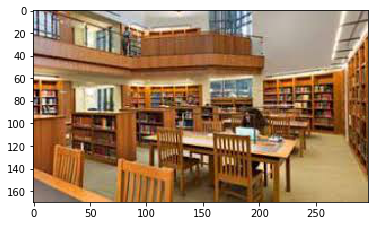

In [272]:
url_path = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRwjH0YOG98ardhxs_Xr9rC6uroF09VDAoote6GjXnfWO9g6YmB"    
show_cap(url_path)

a man in a room with a laptop


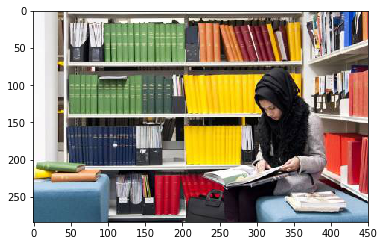

In [274]:
url_path = "http://static.arts.ac.uk/thumbs/beta/www.arts.ac.uk/media/arts/study-at-ual/library-services/images/homepage-new/4-student_reading_by_bound_journals-LCF_Library_2013_11_08_by_Ana_Escobar_1306.jpg/w%3D450%2Ch%3D0%2Cq%3D70"    
show_cap(url_path)

a man is holding a bat on a field


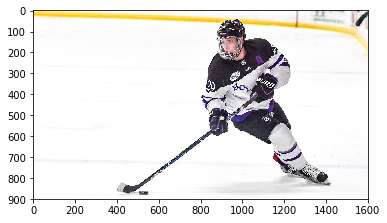

In [277]:
url_path = "http://image.cdnllnwnl.xosnetwork.com/pics33/0/TJ/TJJLECNBRYRVJHO.20170223224018.jpg"    
show_cap(url_path)

a man holding a banana in his mouth


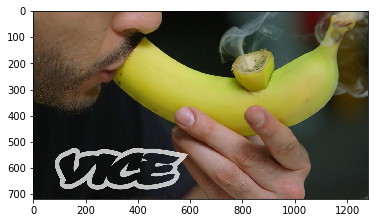

In [286]:
url_path = "https://i.ytimg.com/vi/_7w0C1YhWrw/maxresdefault.jpg"    
show_cap(url_path)

a man holding a remote control in his mouth


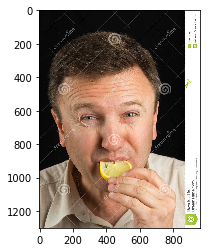

In [291]:
url_path = "https://thumbs.dreamstime.com/z/man-eats-lemon-black-background-32387491.jpg"    
show_cap(url_path)

a pizza with a pizza on it


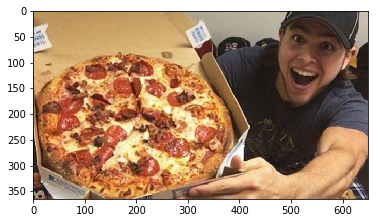

In [294]:
url_path = "http://cdn.newsapi.com.au/image/v1/b32b115ff67dcab1489f6aedce32b6d8"    
show_cap(url_path)

a man in a blue shirt is holding a white umbrella


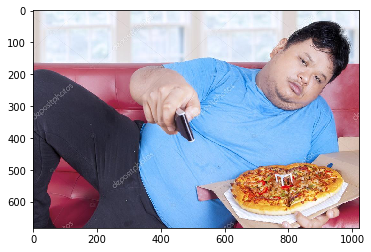

In [295]:
url_path = "https://st.depositphotos.com/1252160/4918/i/950/depositphotos_49187059-stock-photo-man-eats-pizza-while-watching.jpg"    
show_cap(url_path)

# examples where network fails 

a man in a blue shirt is riding a bicycle


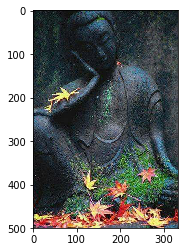

In [216]:
url_path = "https://i.pinimg.com/564x/97/b1/29/97b129365975f74af986b328a1d530a7.jpg"    
show_cap(url_path)

a table with a bunch of bananas on it


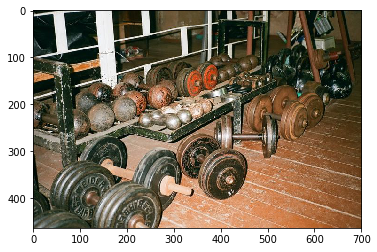

In [279]:
url_path = "https://s00.yaplakal.com/pics/pics_original/2/1/2/8486212.jpg"    
show_cap(url_path)

a man in a black shirt and a cat


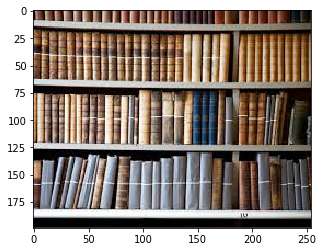

In [273]:
url_path = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcT9Q7wjlut-E0EuseBSTUq6Yq3dLmfEGp1jHUlW0pLN6snO0u-0Iw"    
show_cap(url_path)

a tall building with a clock on it


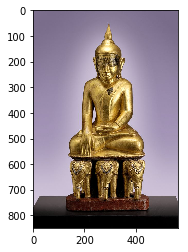

In [218]:
url_path = "https://i.pinimg.com/564x/93/fe/cc/93feccafef7f1b65e4ca9082a3d5e827.jpg"    
show_cap(url_path)

a black bear with a black bear


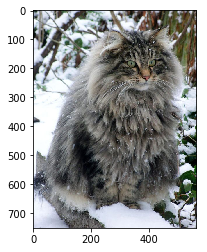

In [219]:
url_path = "https://i.pinimg.com/564x/48/07/e5/4807e5cbd5456ebe2129c1ea6aa44661.jpg"    
show_cap(url_path)

a black and white cat sitting on a bench


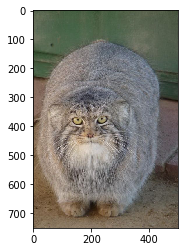

In [220]:
url_path = "https://i.pinimg.com/564x/a2/e5/5b/a2e55b4913273db4d9f45688ba90c0a3.jpg"    
show_cap(url_path)

a man standing on a skateboard in the air


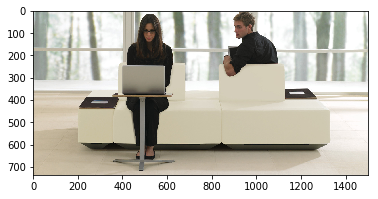

In [250]:
url_path = "https://d2r72yk5wmppdj.cloudfront.net/m/0569bb503f34d6c5/Low-Teknion-dna-Lounge-Seating---Front-View---Freestanding-Laptop-Table---Side-Table-tif.jpg"    
show_cap(url_path)

a man holding a tennis racket on a court


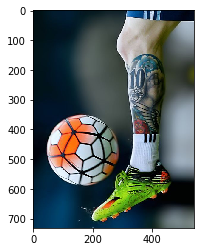

In [244]:
url_path = "https://i.pinimg.com/564x/a2/1b/6d/a21b6d2b9f05e72ab3e3cf4a36522707.jpg"    
show_cap(url_path)

a man in a suit and a woman standing in front of a building


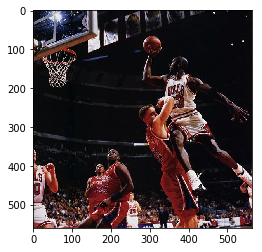

In [237]:
url_path = "https://i.pinimg.com/564x/15/5a/01/155a016fb76b92565efb8ae1ffabc5a5.jpg"    
show_cap(url_path)

a man is on a blue and white motorcycle


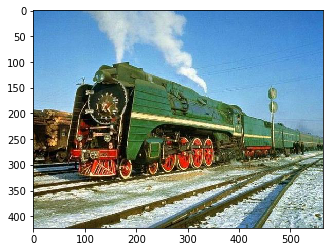

In [230]:
url_path = "https://i.pinimg.com/564x/c4/9e/38/c49e38bcbad646bc9cab2c2a13ab66c3.jpg"    
show_cap(url_path)

a man is flying a kite on a cloudy day


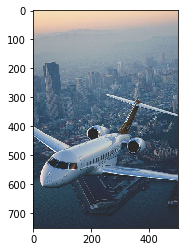

In [224]:
url_path = "https://i.pinimg.com/564x/e1/c4/ef/e1c4ef856ac9decdf21eebe298a40f6e.jpg"    
show_cap(url_path)

a man is standing on a motorcycle


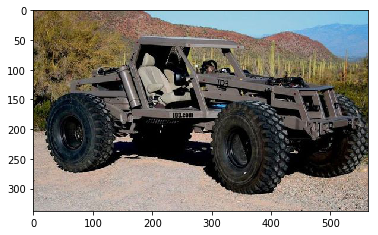

In [233]:
url_path = "https://i.pinimg.com/564x/93/ad/fd/93adfd4b94d51eac549ad06b5cceab57.jpg"    
show_cap(url_path)

a man holding a toothbrush in his mouth


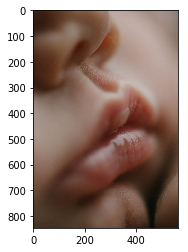

In [234]:
url_path = "https://i.pinimg.com/564x/f3/85/e8/f385e88fe50910ab732766342dc33757.jpg"    
show_cap(url_path)

a bathroom with a toilet and a sink


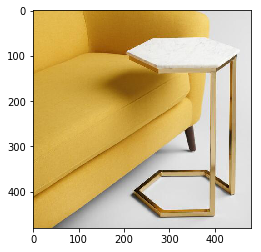

In [248]:
url_path = "https://ii.worldmarket.com/fcgi-bin/iipsrv.fcgi?FIF=/images/worldmarket/source/69462_XXX_v6.tif&wid=480&cvt=jpeg"    
show_cap(url_path)

a man holding a cell phone in his hand


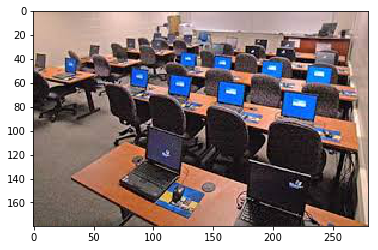

In [251]:
url_path = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQcYYZr98YRgargyXU4sUPTiOrtWRv_PmHssQTRYfACRvTOsFl18g"    
show_cap(url_path)

a man is standing in a living room


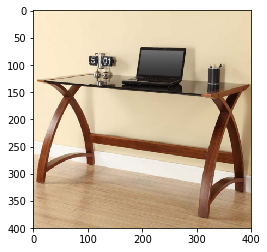

In [253]:
url_path = "https://www.choicefurnituresuperstore.co.uk/images/Jual-Furnishings/Jual-Curve-Oak-and-Walnut-Office-Collection/2-Jual-Curve-Walnut-Laptop-Table-PC201-1300LT.jpg"    
show_cap(url_path)

a man riding a wave on a surfboard


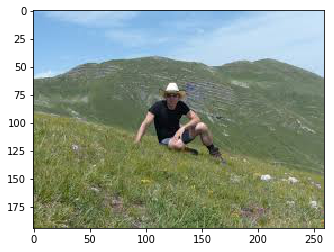

In [268]:
url_path = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQwVULXxr1-OaRKFrYPvOJULfhNnZVuJ-ZbsizCxH1lL545LBZD4w"    
show_cap(url_path)

a man in a green shirt is eating a piece of water


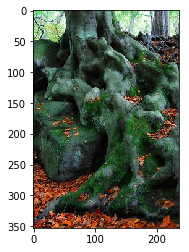

In [222]:
url_path = "https://i.pinimg.com/564x/d4/f6/6c/d4f66c286d66ea11b355ece133016af0.jpg"    
show_cap(url_path)

a man is standing on a bench in the water


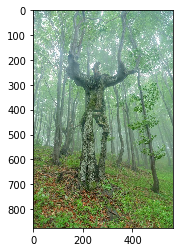

In [223]:
url_path = "https://i.pinimg.com/564x/97/db/be/97dbbe6f45201554e033bf7d4608f764.jpg"    
show_cap(url_path)

# grading

* base 5 if it compiles and trains without exploding
* +1 for finding representative set of reference examples
* +2 for providing 10+ examples where network provides reasonable captions (at least sometimes :) )
  * you may want to predict with sample=False and deterministic=True for consistent results
  * kudos for submitting network params that reproduce it
* +2 for providing 10+ examples where network fails IF you also got previous 10 examples right


* bonus points for experiments with architecture and initialization (see above)
* bonus points for trying out other pre-trained nets for captioning
* a whole lot of bonus points if you also train via metric learning
 * image -> vec
 * caption -> vec (encoder, not decoder)
 * loss = correct captions must be closer, wrong ones must be farther
 * prediction = choose caption that is closest to image
* a freaking whole lot of points if you also obtain statistically signifficant results the other way round
 * take caption, get closest image